In [43]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from DataGeneration import GenerateHARData, GenerateHAPTData
# load data
X, y = GenerateHARData().run()
# trainsform data
XT = torch.from_numpy(X)
XT = XT.transpose(1,2).float() #input is (N, Cin, Lin) = Ntimesteps, Nfeatures, 128
yT = torch.from_numpy(y).float()

In [44]:
# Data Preparation
# dataset definition
from torch.utils.data import Dataset, random_split, DataLoader
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, X, y):
        # store the inputs and outputs
        self.X = X
        self.y = y
 
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
    
    def get_splits(self, train_rate):
        n_data = len(self.X)
        train_size = int(n_data*train_rate)
        test_size = n_data - train_size
        return random_split(self, [train_size, test_size])


data = CSVDataset(XT, yT)
train, test = data.get_splits(train_rate=0.8)
# create a data loader for train and test sets
train_dl = DataLoader(train, batch_size=32, shuffle=True)
test_dl = DataLoader(test, batch_size=1024, shuffle=False)

In [45]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

class OneDCNN(nn.Module):
    def __init__(self, n_timesteps, n_features, n_outputs):
        super(OneDCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(n_features, 64, kernel_size=7),
            nn.ReLU(),
            nn.Conv1d(64, 32, kernel_size=7),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(2))
        self.layer2 = nn.Flatten()
        self.layer3 = nn.Sequential(
            nn.Linear(1856,100),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Linear(100,n_outputs),
            nn.Softmax(dim=1))
       
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

In [59]:
from sklearn.metrics import accuracy_score
def train_model(train_dl, model):
    # define the optimization
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    # enumerate epochs
    predictions, actuals = list(), list()
    for epoch in range(10):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
            # record
            predictions.append(yhat.detach().numpy())
            actuals.append(targets.numpy())
        predictions, actuals = np.vstack(predictions), np.vstack(actuals)
        acc = accuracy_score(actuals, predictions)
        print(f"Epoch: {epoch+1}; Accuracy: {acc}")

n_timesteps =  XT.shape[2]
n_features = XT.shape[1]
n_outputs = yT.shape[1]
model = OneDCNN(n_timesteps, n_features, n_outputs)
train_model(train_dl, model)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

Epoch: 0; Accuracy: 0.7540887850467289
Epoch: 1; Accuracy: 0.8638045171339563
Epoch: 2; Accuracy: 0.8693535825545171
Epoch: 3; Accuracy: 0.9160825545171339
Epoch: 4; Accuracy: 0.922702492211838
Epoch: 5; Accuracy: 0.9230919003115264
Epoch: 6; Accuracy: 0.9387655763239875
Epoch: 7; Accuracy: 0.931756230529595
Epoch: 8; Accuracy: 0.9017718068535826
Epoch: 9; Accuracy: 0.9365264797507789
Done!


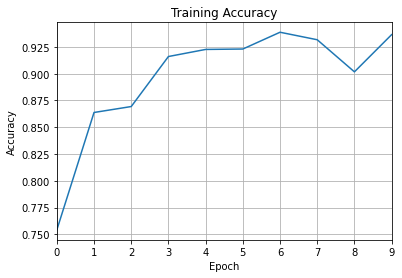

In [35]:
# Model Deifinition
num_epochs = 10
batch_size = 32

n_timesteps =  XT.shape[2]
n_features = XT.shape[1]
n_outputs = yT.shape[1]
total_step = len(XT)

model = OneDCNN(n_timesteps, n_features, n_outputs).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loss_list = []
acc_list = []
acc_list_epoch = []
for epoch in range(num_epochs):
    correct_sum = 0
    for i in range(int(np.floor(total_step/batch_size))): # split data into batches
        XT_seg = XT[i*batch_size:(i+1)*batch_size]
        yT_seg = yT[i*batch_size:(i+1)*batch_size]
        # Run the forward pass
        outputs = model(XT_seg)
        loss = criterion(outputs, yT_seg)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Track the accuracy
        total = yT_seg.size(0)
        _, predicted = torch.max(outputs, 1)
        _, actual = torch.max(yT_seg, 1)
        correct = (predicted == actual).sum().item()
        correct_sum = correct_sum + (correct/total)
        acc_list.append(correct / total)
    
    print(f"Epoch: {epoch}; Accuracy: {correct_sum/int(np.floor(total_step/batch_size))}")
    acc_list_epoch.append(correct_sum/int(np.floor(total_step/batch_size)))
print("Done!")

#plot the training accuracy
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(acc_list_epoch)
plt.show()

In [33]:
predicted

tensor([0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])

In [34]:
actual

tensor([0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Conv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.models import Model

verbose=1
epochs=5
batch_size=32
filters=32
kernel=7
feature_num=100
# get dimension
n_timesteps =  X.shape[1]
n_features = X.shape[2]
n_outputs = y.shape[1]
# define model structure
model = Sequential()
model.add(Conv1D(filters=filters, kernel_size=kernel, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=filters, kernel_size=kernel, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(feature_num, activation='relu', name="feature"))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 122, 32)           2048      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 116, 32)           7200      
_________________________________________________________________
dropout (Dropout)            (None, 116, 32)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 58, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1856)              0         
_________________________________________________________________
feature (Dense)              (None, 100)               185700    
_________________________________________________________________
dense (Dense)                (None, 6)                 6